In [1]:
setwd("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Analysis/MEA-seq/WGCNA_sPLSR")

In [2]:
library(tibble)
library(dplyr)
library(tidyr)
library(ggplot2)
library(tidyverse)
library(DESeq2)
library(tidyverse)
library(WGCNA)
library(mixOmics)
library(writexl)
library(RColorBrewer)
library(stringr)
library(pheatmap)

Warning message:
"package 'tibble' was built under R version 4.2.3"
Warning message:
"package 'dplyr' was built under R version 4.2.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'tidyr' was built under R version 4.2.3"
Warning message:
"package 'tidyverse' was built under R version 4.2.3"
Warning message:
"package 'readr' was built under R version 4.2.3"
Warning message:
"package 'purrr' was built under R version 4.2.3"
Warning message:
"package 'stringr' was built under R version 4.2.3"
Warning message:
"package 'forcats' was built under R version 4.2.3"
Warning message:
"package 'lubridate' was built under R version 4.2.3"
── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ lubridate 1.9.3     

In [3]:
MEA_var<-read.csv("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Analysis/MEA-seq/patients_normalized_hier_PC13.csv")
mea_seq_samples<-MEA_var$sample
MEA_var<-MEA_var[-length(MEA_var)]#remove cluster variable, not used for this analysis

In [4]:
counts<-read.table("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Analysis/RNA-seq/PRPS_integration_neurons/ruviii.2000.norm_voom.txt")
rownames(counts)<-counts$Gene
counts <- counts[, -ncol(counts)]
#replace "." to "-" for colnames
colnames_counts<-colnames(counts)
colnames_counts<-gsub("\\.", "-", colnames_counts)
colnames_counts<-str_replace_all(colnames_counts, "SMARCB1_KSS_CRISPR", "SMARCB1_KSS-CRISPR") #to align 
colnames(counts)<-colnames_counts

samples_info<-read.csv("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Code/0.Data/RNAseq_data/samples_info.csv")
samples_info$Well_ID <- sub(".*_", "", samples_info$sample)
rownames(samples_info)<-samples_info$sample
sampleTable<-samples_info
sampleTable_measeq<-sampleTable[mea_seq_samples,]
sampleTable_measeq$syndrome <- factor(sampleTable_measeq$syndrome, levels = c("control", setdiff(unique(sampleTable_measeq$syndrome), "control")))

sampleTable_measeq <- sampleTable_measeq[order(sampleTable_measeq$syndrome, sampleTable_measeq$group), , drop = FALSE]
samples_order<-sampleTable_measeq$sample

In [5]:
cell_lines<-read.csv("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Code/0.Data/cell_lines/cell_lines.csv")
MEA_var$cell_line<-cell_lines$cell_line_v2[match(MEA_var$Phenotype,cell_lines$Phenotype)]
MEA_var$sample_show<-paste0(MEA_var$cell_line,"_",MEA_var$Well_Label)

In [6]:
rownames(MEA_var)<-MEA_var$sample

MEA_var_num<-MEA_var %>% select_if(is.numeric)

In [7]:
freq_WGCNA<-read.table("freq_WGCNA_1C_X40_Y10_10000.txt")
freq_MEA<-read.table("freq_MEA_1C_X40_Y10_10000.txt")

In [8]:
# Choose stable genes: e.g., selected in >= 50% of bootstraps
n_boot <- 10000
stable_WGCNA <- freq_WGCNA[freq_WGCNA$Freq >= 0.97*n_boot ,"Var1"]
#stable_WGCNA2 <- names(freq_WGCNA2[freq_WGCNA2 >= 0.5*n_boot])
stable_MEA <-freq_MEA[freq_MEA$Freq >= 0.1*n_boot ,"Var1"]

In [9]:
module_eigengenes<-read.csv("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Analysis/RNA-seq/PRPS_integration_neurons/WGCNA/module_eigengenes_NT_signed_sp16.csv")
rownames(module_eigengenes)<-module_eigengenes$X
module_eigengenes<-module_eigengenes[mea_seq_samples,]
module_eigengenes<-drop_na(module_eigengenes)
module_eigengenes<-module_eigengenes[-1]


In [10]:
relevant_module_eigengenes<-module_eigengenes[,stable_WGCNA]

In [11]:
mat <- as.matrix(relevant_module_eigengenes)   

In [12]:
sample_loadings<-read.csv("sample_loadings.csv")
sample_loadings_dist<-sample_loadings[,c("sample","Transcriptome","Activity")]
sample_loadings_dist$sample_show<-MEA_var$sample_show[match(sample_loadings_dist$sample,MEA_var$sample)]
rownames(sample_loadings_dist)<-sample_loadings_dist$sample_show


In [13]:
sample_loadings_dist<-sample_loadings_dist[-c(1,4)]

In [14]:
mat_scaled <- scale(sample_loadings_dist)  # z-score each column

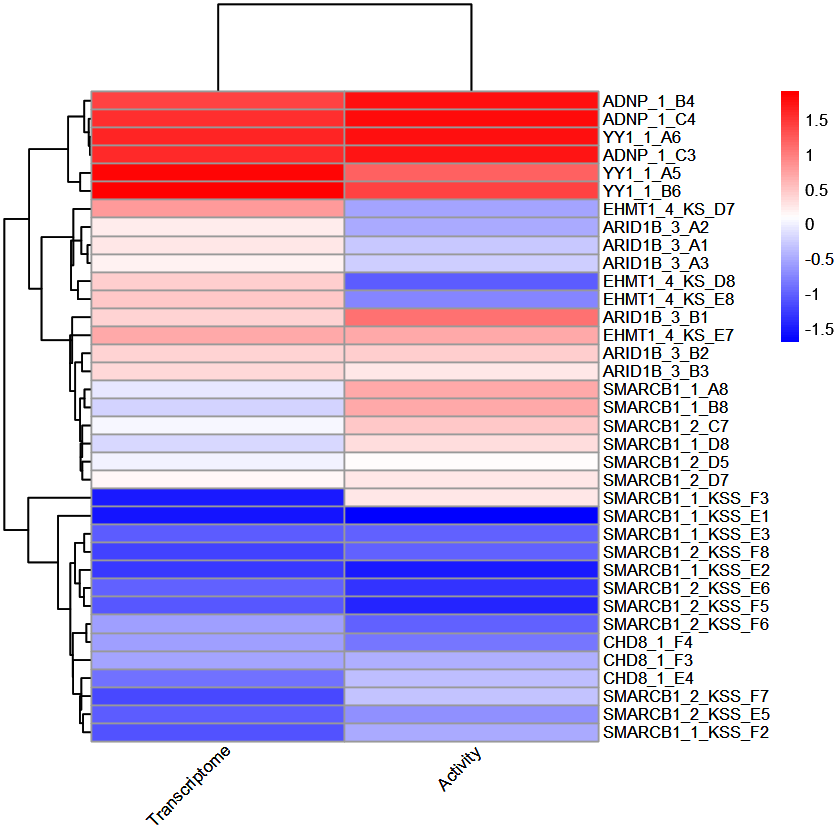

In [15]:
p<-pheatmap(mat_scaled,
         scale = "none",             # already scaled
         clustering_distance_rows = "euclidean",
         clustering_distance_cols = "euclidean",  # optional for 2 columns
         clustering_method = "median",
         color = colorRampPalette(c("blue", "white", "red"))(100),
         show_rownames = TRUE,
         show_colnames = TRUE,
            angle_col = 45)
ggsave("heatmap_Activity_Transcriptome_components.pdf",bg = "transparent",
                  width = 4,   # inches
                  height = 7,   # inches
                plot=p
        )
p

In [ ]:
#now, follow this order to plot samples. make a new order of the genemodules respecting these ones, and then clasify expression activiyt within
#transcirptimc clusters

In [16]:
row_order <- p$tree_row$order  # numeric indices of rows in the clustered order
row_names_ordered <- p$tree_row$labels[row_order]  # sample names in order
row_names_ordered<-MEA_var$sample[match(row_names_ordered,MEA_var$sample_show)]

In [17]:
#normalized expression
#yes show heatm. order samples based on hier clustering on the MEA? but include them all...
relevant_modules<-colnames(relevant_module_eigengenes)
norm_df<-read.table("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Analysis/RNA-seq/PRPS_integration_neurons/PRPS_voom_norm_control.txt")
norm_df_samples<-gsub("\\.", "-", colnames(norm_df))
colnames(norm_df)<-norm_df_samples
gsg <- goodSamplesGenes(t(norm_df))
#summary(gsg)

gsg$allOK

# table(gsg$goodGenes)
# table(gsg$goodSamples)
norm_df <- norm_df[gsg$goodGenes == TRUE,]
norm.counts<-t(norm_df)
norm.counts_df<-as.data.frame(norm.counts)

samples_order<-row_names_ordered
norm.counts_df<-as.data.frame(norm.counts)
norm.counts_df = norm.counts_df[match(samples_order, rownames(norm.counts_df)),]
norm.counts_df_corder<-norm.counts_df[samples_order,]
norm.counts_df_corder_sc<-scale(norm.counts_df_corder) #scale again?
#norm.counts_df_corder_nosc<-
genes_modules<-read.csv("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Analysis/RNA-seq/PRPS_integration_neurons/WGCNA/genes_modules_sp16.csv")
rownames(genes_modules)<-genes_modules$X
genes_modules<-genes_modules[-1]
genes_modules$module<-paste0("ME",genes_modules$module)
genes_modules<-genes_modules[genes_modules$module %in% relevant_modules,]
genes_modules<-droplevels(genes_modules)
genes_modules_s<-split(genes_modules,f=genes_modules$module)
MM_list<-genes_modules_s[relevant_modules]

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

In [18]:
full_signature<-lapply(MM_list, function(x) x[, "gene"])
full_signature<-unlist(full_signature, use.names=FALSE)

In [19]:
relevant_module_eigengenes<-relevant_module_eigengenes[row_names_ordered,]


In [20]:
relevant_module_eigengenes$sample<-rownames(relevant_module_eigengenes)
relevant_module_eigengenes$sample_show<-MEA_var$sample_show[match(relevant_module_eigengenes$sample,MEA_var$sample)]
rownames(relevant_module_eigengenes)<-relevant_module_eigengenes$sample_show

In [21]:
relevant_module_eigengenes<-relevant_module_eigengenes[-c(8,9)]

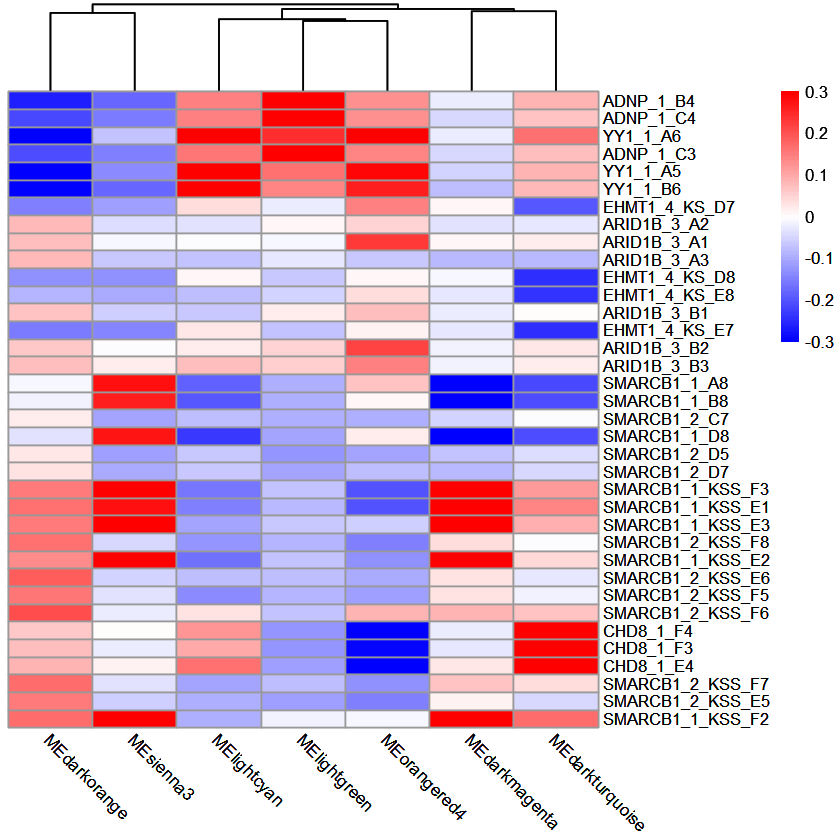

In [22]:
# Determine the max absolute value for symmetric color scaling
max_val <- max(abs(relevant_module_eigengenes), na.rm = TRUE)

p<- pheatmap(relevant_module_eigengenes,
              scale = "none",
              cluster_rows = FALSE,
              cluster_cols = TRUE,
              clustering_distance_cols = "euclidean",
              clustering_method = "single",
              color = colorRampPalette(c("blue","white","red"))(100),
              breaks = seq(-0.3, 0.3, length.out = 101),  # symmetric breaks
              show_rownames = TRUE,
              show_colnames = TRUE,
            angle_col = 315)

ggsave("heatmap_gene_modules_noscaled_limits.pdf",bg = "transparent",
                  width = 5.3,   # inches
                  height = 7,   # inches
                plot=p
        )
p

In [23]:
trn_clusters<-list(clust1 = c('ADNP_1_B4','ADNP_1_C4','YY1_1_A6','ADNP_1_C3','YY1_1_A5','YY1_1_B6'),
                   clust2 = c('EHMT1_4_KS_D7','ARID1B_3_A2','ARID1B_3_A1','ARID1B_3_A3','EHMT1_4_KS_D8','EHMT1_4_KS_E8','ARID1B_3_B1','EHMT1_4_KS_E7','ARID1B_3_B2','ARID1B_3_B3'),
                  clust3 = c('SMARCB1_1_A8','SMARCB1_1_B8','SMARCB1_2_C7','SMARCB1_1_D8','SMARCB1_2_D5','SMARCB1_2_D7'),
                   clust4 = c('SMARCB1_1_KSS_E1','SMARCB1_1_KSS_E3','SMARCB1_2_KSS_F8','SMARCB1_1_KSS_E2','SMARCB1_2_KSS_E6','SMARCB1_2_KSS_F5','SMARCB1_2_KSS_F6','CHD8_1_F4','CHD8_1_F3','CHD8_1_E4','SMARCB1_2_KSS_F7','SMARCB1_2_KSS_E5','SMARCB1_1_KSS_F2'))

#remove 'SMARCB1_KSS_F3', form clust4

In [24]:
sampleTable_measeq$sample_show<-MEA_var$sample_show[match(sampleTable_measeq$sample,MEA_var$sample)]
rownames(sampleTable_measeq)<-sampleTable_measeq$sample_show

In [25]:
# add some constraints to account for nested values
# Suppose relevant_module_eigengenes is a samples x modules matrix
ME_sd <- apply(module_eigengenes, 2, sd, na.rm = TRUE)
ME_sd_th<-mean(ME_sd)*0.5 #with gernal median
# Compute per-module SD across all samples
ME_sd <- apply(relevant_module_eigengenes, 2, sd, na.rm = TRUE)

# Define per-module threshold (30% of module SD)
ME_sd_th_module <- ME_sd * 0.3
# function: run Wilcoxon tests per cluster
test_cluster_wilcox_consistent <- function(cluster_name, cluster_samples, ME_matrix, sampleTable_measeq, prop_threshold = 0.8) {
  # ---------------------------
  # 1. subset eigengenes for cluster
  # ---------------------------
  ME_sub <- ME_matrix[cluster_samples, , drop = FALSE]
  
  # ---------------------------
  # 2. Wilcoxon test per module
  # ---------------------------
  results <- apply(ME_sub, 2, function(x) {
    wt <- suppressWarnings(wilcox.test(x, mu = 0))  # warning suppressed for ties
    c(median = median(x),
      p = wt$p.value)
  })
  
  df <- as.data.frame(t(results))
  df$module <- rownames(df)
  df$p_adj <- p.adjust(df$p, method = "fdr")
  df$threshold <- ME_sd_th_module[as.character(df$module)]

  # assign direction based on median
  df <- df %>%
    mutate(direction = case_when(
      p < 0.05 & median > threshold  ~ "up",
      p < 0.05 & median < -threshold  ~ "down",
      TRUE ~ "ns"
    ))
  
  # ---------------------------
  # 3. Prepare ME_df with sample and group info
  # ---------------------------
  ME_df <- ME_sub %>%
    as.data.frame() %>%
    rownames_to_column("sample_show") %>%
    left_join(sampleTable_measeq[, c("sample_show", "group")], by = "sample_show")
  
  # ---------------------------
  # 4. Compute per-cell-line proportion-based consistency
  # ---------------------------
  group_sign <- function(x, prop_threshold) {
    prop_pos <- mean(x > 0, na.rm = TRUE)
    prop_neg <- mean(x < 0, na.rm = TRUE)
    
    if (prop_pos >= prop_threshold) {
      "up"
    } else if (prop_neg >= prop_threshold) {
      "down"
    } else {
      "mixed"
    }
  }
  
  ME_by_group <- ME_df %>%
    group_by(group) %>%
    summarise(across(where(is.numeric), ~ group_sign(.x, prop_threshold)), .groups = "drop")
  
  print(ME_by_group, width = Inf)  # inspect per-cell-line consistency
  
  # ---------------------------
  # 5. Across-group consistency
  # ---------------------------
  consistency <- apply(ME_by_group[,-1], 2, function(vals) {
    if (all(vals == "up")) {
      "up"
    } else if (all(vals == "down")) {
      "down"
    } else {
      "mixed"
    }
  })
  
  df$consistent_direction <- consistency[df$module]
  
  # stricter significance: Wilcoxon significant AND consistent across groups
  df <- df %>%
    mutate(consistent_significance = case_when(
      direction == "up" & consistent_direction == "up" ~ "up",
      direction == "down" & consistent_direction == "down" ~ "down",
      TRUE ~ "ns"
    ))
  
  # assign cluster name
  df$cluster <- cluster_name
  
  df
}

# ---------------------------
# 6. Run per cluster
# ---------------------------
cluster_results <- purrr::imap(trn_clusters, 
                                ~ test_cluster_wilcox_consistent(.y, .x,
                                    ME_matrix = relevant_module_eigengenes,
                                    sampleTable_measeq = sampleTable_measeq,
                                    prop_threshold = 0.8))  # 80% replicates agreement
cluster_results <- do.call(rbind, cluster_results)
#cluster_results

# A tibble: 2 × 8
  group   MEdarkmagenta MEdarkorange MEdarkturquoise MElightcyan MElightgreen
  <chr>   <chr>         <chr>        <chr>           <chr>       <chr>       
1 ADNP_CR down          down         up              up          up          
2 YY1_CR  down          down         up              up          up          
  MEorangered4 MEsienna3
  <chr>        <chr>    
1 up           down     
2 up           down     
# A tibble: 2 × 8
  group           MEdarkmagenta MEdarkorange MEdarkturquoise MElightcyan
  <chr>           <chr>         <chr>        <chr>           <chr>      
1 ARID1B_CRISPR_1 down          up           mixed           mixed      
2 EHMT1_CR        mixed         down         down            mixed      
  MElightgreen MEorangered4 MEsienna3
  <chr>        <chr>        <chr>    
1 mixed        up           down     
2 down         up           down     
# A tibble: 2 × 8
  group              MEdarkmagenta MEdarkorange MEdarkturquoise MElightcyan
  <chr>       

In [26]:
write.csv(cluster_results,"gene_modules_cluster_wilcox_th_sd03_prop08.csv")